<center style="font-size:30px; font-weight:bold">DATA7703, Practical 11 Solutions<center>
    <br>
<center style="font-size:20px">2021 Semester 2<center>

**Q1** **(a)** We load the dataset and generate the required boxplots below. We can see that the three species have very different petal length and petal width values, and thus both features are good discriminators for the species. On the other hand, sepal length and sepal width seem to have limited discriminating power on their own. Thus we expect petal length and petal width to be important with have similar importance values, while sepal length and sepal width are expected to be not very important.

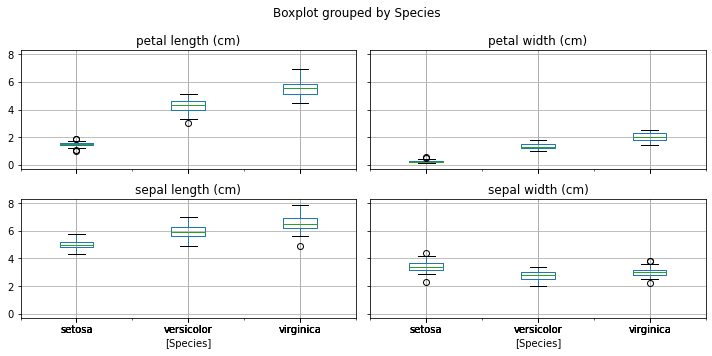

In [1]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

iris = load_iris()
X, y = load_iris(return_X_y=True)

data = pd.DataFrame(X, columns=iris.feature_names)
data['Species'] = iris.target_names[y]
data.boxplot(by='Species', figsize=(10,5))
plt.tight_layout()
plt.show()

**(b)** We train 10 random forest, and compute the impurity-based importance scores and the permutation importance scores for each of them below.

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

np.random.seed(1)

impurity_importancs = []
permutation_importances = []

for i in range(10):
    clf = RandomForestClassifier()
    clf.fit(X, y)
    impurity_importancs.append(clf.feature_importances_)
    permutation_importances.append(permutation_importance(clf, X, y)['importances_mean'])
    
impurity_importancs = np.array(impurity_importancs)
permutation_importances = np.array(permutation_importances)

To help interpreting the importance scores, the feature names are shown below.

In [3]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

The averages and standard errors of the importance scores are shown below. While the the impurity-based importance scores and the permutation importance scores are different in magnitude, both types of importance scores suggest that petal length and petal width are important with roughly the same importance scores, and sepal length and sepal width are not very important. This agrees with our expectation in (a).

In [4]:
impurity_importancs.mean(axis=0), impurity_importancs.std(axis=0)

(array([0.09359133, 0.02073693, 0.43854354, 0.4471282 ]),
 array([0.0128936 , 0.00266484, 0.01822924, 0.01258144]))

In [5]:
permutation_importances.mean(axis=0), permutation_importances.std(axis=0)

(array([0.01546667, 0.01053333, 0.25373333, 0.25866667]),
 array([0.00280951, 0.0031805 , 0.08084894, 0.09850979]))

**(c)** We train a logistic regression model and compute the permutation importances of the features using the model as follows. Note that while both sepal length and sepal width have low importance scores, and petal length and petal width have higher importance scores, the importance scores of petal length and petal width are very different. This is because petal length and petal width are highly correlated, and it turns out that the logistic regression model chooses to put a larger weight on petal length in this case.

In [6]:
from sklearn.linear_model import LogisticRegression

np.random.seed(1)

clf = LogisticRegression(max_iter=1000)
clf.fit(X, y)
permutation_importance(clf, X, y)

{'importances_mean': array([0.008     , 0.016     , 0.58266667, 0.15466667]),
 'importances_std': array([0.00884433, 0.008     , 0.05442222, 0.016     ]),
 'importances': array([[ 0.00666667,  0.02      , -0.00666667,  0.01333333,  0.00666667],
        [ 0.02      ,  0.00666667,  0.02      ,  0.02666667,  0.00666667],
        [ 0.56666667,  0.52666667,  0.52666667,  0.65333333,  0.64      ],
        [ 0.14666667,  0.14666667,  0.13333333,  0.17333333,  0.17333333]])}

**Q2** **(a)** This is a GP with noise-free observations.
GP has perfect training set R2, but a negative test set R2, while the training set R2 and test set R2 for linear regression are 0.59 and 0.61 respectively.
This suggests that GP has severely overfitted.

In [7]:
from sklearn.datasets import fetch_california_housing
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, RBF, Matern
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = fetch_california_housing(return_X_y=True)
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.8,
random_state=42)
# train and test a linear regression kernel
ols = LinearRegression()
ols.fit(X_tr, y_tr)
print('Linear regression R2 - train: %.2f; test: %.2f' % (ols.score(X_tr, y_tr), ols.score(X_ts, y_ts)))
# train and test a GP with Matern kernel 
kernel = Matern()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)
gpr.fit(X_tr, y_tr)
print('Gaussian process R2 - train: %.2f; test: %.2f' % (gpr.score(X_tr, y_tr), gpr.score(X_ts, y_ts)))

Linear regression R2 - train: 0.59; test: 0.61
Gaussian process R2 - train: 1.00; test: -0.15


(b) The four variants are trained and tested below.
We can see that the best variant is variant (iv), which is a noisy GP using scaled Matern kernel and normalized inputs.
This suggests that input normalization, a noisy observation model, and an appropriate kernel are all important:
* Importance of input normalization can be seen by comparing (iii) and (iv) with (a), (i), (ii).
* Importance of a noisy observation model can be seen by comparing (iv) and (v).
* Importance of a kernel can be seen by comparing (ii), (i) and (a).

In [8]:
# (i)
kernel = RBF()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)
gpr.fit(X_tr, y_tr)
print('Gaussian process R2 - train: %.2f; test: %.2f' % (gpr.score(X_tr, y_tr), gpr.score(X_ts, y_ts)))

Gaussian process R2 - train: 1.00; test: -0.71


In [9]:
# (ii)
kernel = ConstantKernel()*Matern()+WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)
gpr.fit(X_tr, y_tr)
print('Gaussian process R2 - train: %.2f; test: %.2f' % (gpr.score(X_tr, y_tr), gpr.score(X_ts, y_ts)))

Gaussian process R2 - train: 0.66; test: 0.14


In [10]:
# (iii)
scaler = StandardScaler()
X_tr_scale = scaler.fit_transform(X_tr)
X_ts_scale = scaler.transform(X_ts)

kernel = Matern()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)
gpr.fit(X_tr_scale, y_tr)
print('Gaussian process R2 - train: %.2f; test: %.2f' % (gpr.score(X_tr_scale, y_tr), gpr.score(X_ts_scale, y_ts)))

Gaussian process R2 - train: 1.00; test: 0.61


In [11]:
# (iv)
kernel = ConstantKernel()*Matern()+WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)
gpr.fit(X_tr_scale, y_tr)
print('Gaussian process R2 - train: %.2f; test: %.2f' % (gpr.score(X_tr_scale, y_tr), gpr.score(X_ts_scale, y_ts)))

Gaussian process R2 - train: 0.84; test: 0.76


In [12]:
# (v)
kernel = ConstantKernel()*Matern()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)
gpr.fit(X_tr_scale, y_tr)
print('Gaussian process R2 - train: %.2f; test: %.2f' % (gpr.score(X_tr_scale, y_tr), gpr.score(X_ts_scale, y_ts)))

Gaussian process R2 - train: 1.00; test: 0.67
